In [1]:
## imports
import pandas as pd
import numpy as np
import re
import requests
import yaml
import tweepy
import pickle
import plotnine
from plotnine import *
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_colwidth', None)

## function to load credentials yaml
def load_creds(path: str):
    with open(path, 'r') as stream:
        try:
            creds = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return(creds)

# 0. Setup: authenticate to Twitter API

In [2]:
## read creds file- replace with path to your creds
creds = load_creds("../my_cred_JH.yaml")


In [3]:
## use bearer token to initialize a tweepy client (connection with twitter API)
client = tweepy.Client(bearer_token= creds['twitter_api']['bearer_token'])

## print type
print(type(client))

<class 'tweepy.client.Client'>


# 1. Use one: pulling recent tweets associated with a hashtag

Here, we're going to pull recent tweets associated with the metoo hashtag. Note that if we want tweets older than a week, we need to either get an academic license (rather than a student one) or use another method (discussion here: https://stackoverflow.com/questions/24214189/how-can-i-get-tweets-older-than-a-week-using-tweepy-or-other-python-libraries) 

The `Cursor` class w/in tweepy allows us to pull while skipping annoying things like pagination

**Example use**: Gallagher et al. look at the use of hashtags #BlackLivesMatter, #AllLivesMatters, and others in days following instances of officer-involved shootings or indictments/non-indictments. They examine things like the different words that are used in tweets containing those hashtags and whether the conversations occur separately or whether those using the #AllLivesMatter hashtag are inserting themselves into BLM conversations: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0195644

## 1.1 Printing tweets and their attributes

In [4]:
## construct a hashtag
## we're filtering out retweets for simplicity
## discussion here of query construction:
## https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query
query = "#metoo -is:retweet is:verified"

tweets_mt = client.search_recent_tweets(query = query, max_results = 100,
                                    tweet_fields = ['created_at',
                                                    'author_id',
                                                   'geo',
                                                   'lang', 
                                                   'public_metrics'],
                                    user_fields = ['description',
                                                  'location',
                                                  'verified',
                                                  'public_metrics'],
                                    expansions = 'author_id',
                                    end_time = "2022-10-13T01:00:00-00:00")


In [5]:
## attributes of the tweet
### iterating over the list of tweets
### and for each tweet, pulling some info (just printing first 5)
tweet_res = [print("""On {}, {} tweeted {} in {} language, which was liked by {}
    """.format(tweet.created_at,
              tweet.author_id,
              tweet.text,
              tweet.lang,
              tweet.public_metrics['like_count']))
for tweet in tweets_mt.data[0:5]]



On 2022-10-13 00:39:49+00:00, 6361512 tweeted What did I miss today? https://t.co/hlgcIgt9Fp Stories via @jennablan @riotta @fbonacci #metoo #metooatfive in en language, which was liked by 3
    
On 2022-10-12 21:30:13+00:00, 726627710404038656 tweeted Justin Fairfax Clearing His Name From #MeToo Scandal with Help of FBI, Others - The Sacramento Observer https://t.co/JWjLzbeFYE in en language, which was liked by 3
    
On 2022-10-12 20:11:30+00:00, 2884771 tweeted Danny Masterson rape trial spotlights Scientology and #MeToo movement https://t.co/PoIrNeLcZE in en language, which was liked by 12
    
On 2022-10-12 19:22:02+00:00, 2711336076 tweeted #MeToo, cinq ans après: «C’est une révolution narrative, les femmes ne sont plus des personnages secondaires» https://t.co/2hVZJOcgfS in fr language, which was liked by 2
    
On 2022-10-12 18:54:38+00:00, 440413534 tweeted #UCLouvain convicted of workplace violence against biology professor who happens to be a woman - Strong measures need to 

## 1.2 Printing attributes of users 

In [6]:
## add attributes of the user
users = {user["id"]: user for user in tweets_mt.includes['users']}

### similarly, iterating over the list of tweets
### and for each tweet, finding its author id and 
### printing some info
for tweet in tweets_mt.data[0:5]:
    u_info = users[tweet.author_id]
    print("""On {}, {}, whose verification status is: {}
    and follower count is: {}
    tweeted: {}
    """.format(tweet.created_at,
              u_info.username,
              u_info.verified,
            u_info.public_metrics['followers_count'],
            tweet.text))

On 2022-10-13 00:39:49+00:00, FGoria, whose verification status is: True
    and follower count is: 43986
    tweeted: What did I miss today? https://t.co/hlgcIgt9Fp Stories via @jennablan @riotta @fbonacci #metoo #metooatfive
    
On 2022-10-12 21:30:13+00:00, LGJustinFairfax, whose verification status is: True
    and follower count is: 17314
    tweeted: Justin Fairfax Clearing His Name From #MeToo Scandal with Help of FBI, Others - The Sacramento Observer https://t.co/JWjLzbeFYE
    
On 2022-10-12 20:11:30+00:00, Newsweek, whose verification status is: True
    and follower count is: 3590603
    tweeted: Danny Masterson rape trial spotlights Scientology and #MeToo movement https://t.co/PoIrNeLcZE
    
On 2022-10-12 19:22:02+00:00, LeTemps, whose verification status is: True
    and follower count is: 68826
    tweeted: #MeToo, cinq ans après: «C’est une révolution narrative, les femmes ne sont plus des personnages secondaires» https://t.co/2hVZJOcgfS
    
On 2022-10-12 18:54:38+00:

## 1.3 Storing that tweet and user information in a dataframe

If we want to work with this as data, instead of iterating and printing, 
want to store in a dataframe

### 1.3.1 Pull attributes/metadata about tweets

In [7]:

### define the attributes (need to be pulled
### in the search_recent_tweets call above)
tweet_attr = ['id',
              'created_at', 'author_id', 
             'text', 'lang', 'geo', 'public_metrics']

### function to iterate over attributes
def pull_attr(one_tweet, which_attr):
    all_attr = [one_tweet[attr] if attr != 'public_metrics'
                else 
                one_tweet[attr]['like_count']
                for attr in which_attr]
    return(all_attr)

### iterate over tweets and pull tweet info
tweets_info_list = [pull_attr(one_tweet, tweet_attr)
              for one_tweet in tweets_mt.data]

### transform into a dataframe
tweets_info_df = pd.DataFrame(tweets_info_list,
                                columns = tweet_attr)

tweets_info_df[tweets_info_df.lang == "en"].sort_values(by = 'public_metrics', 
                           ascending = False).head()


,id,created_at,author_id,text,lang,geo,public_metrics
6,1580267933451763712,2022-10-12 18:43:29+00:00,920905949795246080,"“What 'Me Too' Made Possible,” an essay by Tarana Burke in @TIME for the 5th anniversary of the #MeToo movement. https://t.co/t7EM31L3Ff",en,None,39
2,1580290079766872065,2022-10-12 20:11:30+00:00,2884771,Danny Masterson rape trial spotlights Scientology and #MeToo movement https://t.co/PoIrNeLcZE,en,None,12
13,1580247245445734402,2022-10-12 17:21:17+00:00,141584822,"Actress and celebrity #SherlynChopra is miffed with the makers of the reality television show '#BiggBoss' for including film director #SajidKhan, who was embroiled in the #MeToo controversy in India, back in 2018.\n\nRead: https://t.co/04bgrs01ow\n\n@SherlynChopra https://t.co/M9Gyv9vOyq",en,None,7
4,1580270738153799680,2022-10-12 18:54:38+00:00,440413534,#UCLouvain convicted of workplace violence against biology professor who happens to be a woman - Strong measures need to be taken to stop this if @uclouvain_be wants to restore its reputation. #MeToo #MeTooAcademia #MeTooUCLouvain World News | TakeToNews https://t.co/2sBqobQSPf,en,None,6
5,1580270369197281280,2022-10-12 18:53:10+00:00,88846135,"Actress and celebrity #SherlynChopra is miffed with the makers of the reality television show '#BiggBoss ' for including film director #SajidKhan, who was embroiled in the #MeToo controversy in India, back in 2018.\n\nRead: https://t.co/Yy45DGLWUs\n\n@SherlynChopra https://t.co/w7Tv5p1Djs",en,None,5


### 1.3.2 Pull attributes/metadata about users

In [8]:
### define the user attributes (similarly need to be pulled)
user_attr = ['username', 'description',
             'location', 'verified', 'public_metrics']

### function to iterate over user attributes
def pull_user_attr(one_tweet, which_attr):
    
    one_user = users[one_tweet.author_id]
    all_attr = [one_tweet.author_id] + \
                [one_user[attr] 
                if 
                attr != "public_metrics"
                else 
                one_user[attr]['followers_count']
                for attr in which_attr] 
    return(all_attr)

### iterate over tweets and pull user info
users_info_list = [pull_user_attr(one_tweet, user_attr)
                    for one_tweet 
                    in tweets_mt.data]
user_info_df = pd.DataFrame(users_info_list,
                               columns = ['author_id'] + user_attr)

In [9]:
## merge on author id so that we have
## metadata on both tweets and users
tweets_df = pd.merge(tweets_info_df,
                          user_info_df,
                          on = 'author_id',
                          how = 'left',
                          suffixes = ['_tweet', '_user']).drop_duplicates(subset = 'id')

tweets_df.loc[tweets_df.lang == "en",
             ['text', 'public_metrics_tweet',
             'username', 'description', 
             'public_metrics_user']].sort_values(by = 'public_metrics_tweet', 
                            ascending = False).head()

,text,public_metrics_tweet,username,description,public_metrics_user
6,"“What 'Me Too' Made Possible,” an essay by Tarana Burke in @TIME for the 5th anniversary of the #MeToo movement. https://t.co/t7EM31L3Ff",39,MeTooMVMT,"Working towards eradicating sexual violence by shifting culture, policies, and institutions.",101663
2,Danny Masterson rape trial spotlights Scientology and #MeToo movement https://t.co/PoIrNeLcZE,12,Newsweek,The freedom to disagree.,3590603
14,"Actress and celebrity #SherlynChopra is miffed with the makers of the reality television show '#BiggBoss' for including film director #SajidKhan, who was embroiled in the #MeToo controversy in India, back in 2018.\n\nRead: https://t.co/04bgrs01ow\n\n@SherlynChopra https://t.co/M9Gyv9vOyq",7,ians_india,India's largest independent News Agency,82815
4,#UCLouvain convicted of workplace violence against biology professor who happens to be a woman - Strong measures need to be taken to stop this if @uclouvain_be wants to restore its reputation. #MeToo #MeTooAcademia #MeTooUCLouvain World News | TakeToNews https://t.co/2sBqobQSPf,6,JPvanYpersele,"IPCC Vice-Chair for AR5, climate physicist, Prof UCLouvain. Dedicated to help improving the well-being of all humans & living species equitably through science",20040
5,"Actress and celebrity #SherlynChopra is miffed with the makers of the reality television show '#BiggBoss ' for including film director #SajidKhan, who was embroiled in the #MeToo controversy in India, back in 2018.\n\nRead: https://t.co/Yy45DGLWUs\n\n@SherlynChopra https://t.co/w7Tv5p1Djs",5,iAtulKrishan,"Assistant Editor @ians_india \nEx-@republic , @DeccanChronicle , @mid_day & @TheStatesmanLtd ! views are personal.",18706


## 1.4 Exploring the results

In [10]:
### 1. what percent are diff languages?
tweets_df.lang.value_counts(normalize = True)

en    0.45
fr    0.45
hi    0.05
nl    0.05
Name: lang, dtype: float64

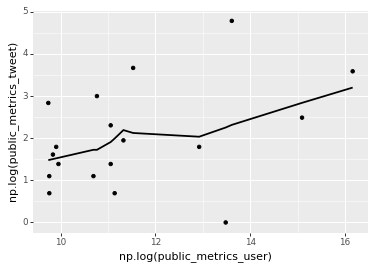

<ggplot: (8728972217062)>

In [11]:
### 2. what's the relationship b/t followers and likes? (logged and removing 0)
(ggplot(tweets_df[(tweets_df.public_metrics_user > 0) &
                  (tweets_df.public_metrics_tweet > 0)], 
                  aes(x = 'np.log(public_metrics_user)', 
                    y = 'np.log(public_metrics_tweet)')) +
geom_point() +
geom_smooth(method = "lowess", se = False))


In [12]:
### 3. search for who's tagged in a tweet - restricting to english language
tag_pat = r".*(@\w+).*"
### iterate over tweets
all_tags = [re.findall(tag_pat, one_tweet) 
            for one_tweet in tweets_df.text[tweets_df.lang == "en"]
           if len(re.findall(tag_pat, one_tweet)) > 0]
### flatten list to count repeats and summarize top
all_tags_onelist = [item for sublist in all_tags for item in sublist]
pd.Series(all_tags_onelist).value_counts()



@SherlynChopra    2
@fbonacci         1
@uclouvain_be     1
@TIME             1
@afa_cwa          1
@journo_shweta    1
dtype: int64

In [13]:
### 4. search for hashtags in a tweet
hash_pat = r".*(\#\w+)\s+.*"
### iterate over tweets
all_hasht = [re.findall(hash_pat, one_tweet) 
            for one_tweet in tweets_df.text
           if len(re.findall(hash_pat, one_tweet)) > 0]

### flatten list to count repeats and summarize top
all_hash_onelist = [item for sublist in all_hasht for item in sublist]
pd.Series(all_hash_onelist).value_counts()

#MeToo             9
#metoo             2
#MeTooUCLouvain    1
#desirmasculin     1
#Watch             1
#FactCheck         1
#SajidKhan         1
dtype: int64

In [14]:
SAVE_BACKUP = False
if SAVE_BACKUP:
    tweets_df.to_pickle("../../../private_data/tweets_w22.pkl")

# 2. Use two: examining relationships between those on the site

- Previous example showed both who tweeted with a lot of likes/high follower counts, and also who they tended to tag in the tweets
- We can also use twitter to form the start of a social network where nodes are different accounts and edges are drawn between followers who follow the same focal account; here, we'll look at a simplified form

**Example use**: Mosleh et al. do a field experiment where they create Twitter bots that either self-identify as Republican or Democrat and then the bots follow people. They look at how the partisanship of the user the bot follows predicts whether the user follows a bot back: https://www.pnas.org/content/118/7/e2022761118.short

In [15]:
## choose a focal account from above
READ_SAVED = True
if READ_SAVED:
    tweets_df = pd.read_pickle("../../public_data/tweets_w22.pkl")


focal_acc_row = tweets_df[tweets_df.username.str.contains("AndyNgo")]
focal_acc_id = focal_acc_row.author_id.iloc[0]

## can also get their id based on username
focal_acc_id_alt = client.get_user(username = "MrAndyNgo").data['id']

assert focal_acc_id == focal_acc_id_alt

In [16]:
## pull user followers (defaults to most recent 100 followers)
follow_focal = client.get_users_followers(id = focal_acc_id,
                                         user_fields = user_attr)

## get data - this time more manually rather than function
user_data = pd.DataFrame({'uname': [user['username'] for user in follow_focal.data],
                          'description': [user['description'] for user in follow_focal.data],
                          'user_id': [user['id'] for user in follow_focal.data],
                         'followers': [user['public_metrics']['followers_count'] 
                                        for user in follow_focal.data]})
user_data.sort_values(by = 'followers', ascending = False)

## can then see who are followers of followers
follow_top_row = user_data[user_data.followers == np.max(user_data.followers)]
follow_top_id = follow_top_row.user_id.iloc[0]

## similarly, get followers and view them (would probably want to write function at this point)
follow_degree2 = client.get_users_followers(id = follow_top_id,
                                         user_fields = user_attr)
user_data_degree2 = pd.DataFrame({'uname': [user['username'] for user in follow_degree2.data],
                          'description': [user['description'] for user in follow_degree2.data],
                          'user_id': [user['id'] for user in follow_degree2.data],
                         'followers': [user['public_metrics']['followers_count'] for user in follow_degree2.data]})
user_data_degree2.sort_values(by = 'followers', ascending = False)

,uname,description,user_id,followers
63,spongeforgotten,Forgotten images from anything relating to SpongeBob SquarePants.,1541585763480965121,21580
71,LassoudryS,un piège ? c’est possible. un complot ? nous verrons- le Z 45-zozz🇫🇷🏴‍☠️🏴󠁧󠁢󠁥󠁮󠁧󠁿 🇳🇱#teampatriotes #NousSommesLes6Millions @ZeZemmourist sur GETTR,635449239,1821
68,nizan22130,#emojiBZH Zemmour#Z0ZZ,1404546271,1354
4,moonieNFTs,NFT Collector | Millionaire | Father of 2 | Metaverse Enthusiast\n\nMAYC 🍌 Doodles 🌈 Azuki ⛩,1572046553749012482,891
87,Dear_O_Dear,Women & Mother #NoThankYou,720728612635287553,789
...,...,...,...,...
11,MassiveGraphite,,1582742642286272515,0
83,camicrumb,,1201828243,0
73,SamMonr0e,,1582625808526344193,0
74,DaveB57780487,,1577456594476240896,0


,uname,description,user_id,followers
15,anamanaguchi,band / guys @polyvinyl 💿,21056214,69266
77,tobias_krebs,Cartoonist\nStoryboard Artist on @Spongebob\n🏆 Australia's cutest cartoonist 🏆\nFreelance Thespian.,1092962319846367233,1098
84,AblackLennox,,4255655009,557
22,DogboyRed2401,(Work In Progress) My Oshis (In Order): 🏆 🌹🐧❄️ 👻🎼,1379585046366019584,426
60,AdmiralKaneki,"🇵🇭 / Him, He / PSO2 Global Ship 1; JP Ship 2",1392735566509142016,411
...,...,...,...,...
91,CharlieJa7c,"Ok l like to draw anime and cartoon and watch them and sing and I like to write stories too ,and that all.",1547746694103646208,0
75,ruimarxyz,temporary account,1423286131127246855,0
97,ZimmermanDorrie,,1582153678882045953,0
2,CleraPalhassa,16y - INFP - dumb girl,1582750887503601664,0


# Use three: extract recent tweets from a specific user

If we have a dataset or panel of users, can get their tweets and extract properties like likes, retweets, etc (most recent ~3200)

**Example use**: Bisbee et al. construct a panel of political science professors use Twitter; they then follow those users and looks at who retweets each other's research, finding that male professors are more likely to pass on research by other male professors than by female professors - https://www.cambridge.org/core/journals/perspectives-on-politics/article/polisci-twitter-a-descriptive-analysis-of-how-political-scientists-use-twitter-in-2019/C8A193C3E939C1ABCD4600DFE8AEF79A

In [17]:
## step 1: choose a focal account and get their numeric id
focal_account = "SenatorHassan"
get_id = client.get_user(username= focal_account, user_fields = user_attr)
hassan_id = get_id.data['id']

## step 2: use the get_users_tweets method to 
## pull recent tweets - here, i'm pulling most recent 100
hassan_tweets_resp = client.get_users_tweets(id = hassan_id,
                                       max_results = 100, 
                                       tweet_fields = tweet_attr)

## step 3: that returns a response with data as an attribute
## to turn into a dataframe, use function above 
hassan_tweets_list = [pull_attr(one_tweet, tweet_attr)
                      for one_tweet in hassan_tweets_resp.data]

### step 4: transform into a dataframe
senator_tweets_df = pd.DataFrame(hassan_tweets_list,
                                columns = tweet_attr)
senator_tweets_df.head()

,id,created_at,author_id,text,lang,geo,public_metrics
0,1582466097760325632,2022-10-18 20:18:13+00:00,946549322,RT @SenKevinCramer: My legislation with @SenatorHassan and @SenBillCassidy to strengthen the Solid Start program helping veterans transitio…,en,None,0
1,1582157663714283522,2022-10-17 23:52:36+00:00,946549322,RT @UnionLeader: A bill that Sen. Maggie Hassan co-wrote to make permanent a program that links retiring vets with federal health care serv…,en,None,0
2,1582118854159126528,2022-10-17 21:18:23+00:00,946549322,Exciting news: my bipartisan Solid Start Act was just signed into law. I’m proud to have worked side-by-side with veterans to help better connect them to VA resources after leaving active duty service. It’s another way to fulfill our country’s promise to support those who served.,en,None,74
3,1582106469549240320,2022-10-17 20:29:11+00:00,946549322,My bipartisan law removed outdated regulations on hearing aids - and now pharmacies will be able to sell them over-the-counter.\n\nMore market competition. Lower costs. And a way to improve the lives of millions impacted by hearing loss. https://t.co/iML905CM08,en,None,72
4,1582075166942642176,2022-10-17 18:24:47+00:00,946549322,"Starting TODAY: pharmacies will begin selling hearing aids over-the-counter. Hearing loss impacts millions of Americans, but too often, hearing aids are difficult to afford.\n\nExcited to see our bipartisan law in action, making hearing aids more available, affordable &amp; accessible.",en,None,90


In [18]:
## do sentiment scoring on the tweet
si_scorer = SentimentIntensityAnalyzer()
senator_tweets_df['compound_sent'] = [si_scorer.polarity_scores(one_tweet)['compound'] 
                                      for one_tweet in senator_tweets_df.text]
senator_tweets_df.sort_values(by = 'compound_sent', ascending = False).head(5)
senator_tweets_df.sort_values(by = 'compound_sent', ascending = False).tail(5)



,id,created_at,author_id,text,lang,geo,public_metrics,compound_sent
2,1582118854159126528,2022-10-17 21:18:23+00:00,946549322,Exciting news: my bipartisan Solid Start Act was just signed into law. I’m proud to have worked side-by-side with veterans to help better connect them to VA resources after leaving active duty service. It’s another way to fulfill our country’s promise to support those who served.,en,None,74,0.9686
10,1580012256469069826,2022-10-12 01:47:31+00:00,946549322,"Chief Garone lived his life in service to our state &amp; country. He represented the best of NH, working selflessly for 50 yrs to keep Derry safe. We’ll be forever grateful for his dedicated service. My prayers are with his family, friends &amp; all who had the privilege of knowing him. https://t.co/CsZwQInI5p",en,None,28,0.9565
93,1568700388932726786,2022-09-10 20:38:12+00:00,946549322,"The Indonesian Festival in Somersworth brings our community together to showcase, celebrate, and share Indonesian culture.\n\nIt was a pleasure to join today’s festival. https://t.co/skz8kpR9Ln",en,None,54,0.9531
38,1575213343832707073,2022-09-28 19:58:21+00:00,946549322,"Caroline Keane organizes the Ready to Learn Fair in Concord to provide free backpacks and school supplies, helping provide the resources for students to succeed.\n\nShe embodies the Granite State spirit of community - and I’m proud to name her Granite Stater of the Month. https://t.co/OEJlXnnEQu",en,None,26,0.9460
17,1578483962858524673,2022-10-07 20:34:38+00:00,946549322,"Public safety is the most fundamental task of any government, and I appreciated the opportunity to ride along today with Manchester PD.\n\nOur officers bravely risk their lives every day to keep us safe, and I’m proud to stand with New Hampshire law enforcement. https://t.co/JyU1ZxamW4",en,None,49,0.9442


,id,created_at,author_id,text,lang,geo,public_metrics,compound_sent
26,1576994496016896000,2022-10-03 17:56:01+00:00,946549322,Hate should have no home in the Granite State.\n\nThe antisemitic vandalism in Laconia is alarming and unacceptable. New Hampshire must always be a place where everyone can pray and live freely. https://t.co/oRZ6dto0ud,en,None,67,-0.6369
77,1570124987037630464,2022-09-14 18:59:03+00:00,946549322,"Republicans’ nationwide abortion ban would make it a crime for doctors to provide critical reproductive care for women, no matter where they live.\n\nA woman and her doctor should make these decisions - not the government.",en,None,336,-0.7410
94,1568613724415737857,2022-09-10 14:53:49+00:00,946549322,"Break stigma. Share resources. Support one another.\n\nAnd call 9-8-8, the suicide and crisis lifeline, if you or someone you know needs support.\n\nWorld Suicide Prevention Day is one day to start a conversation that could change a person’s life forever.\n\n#WSPD2022",en,None,53,-0.8176
88,1568970276406448129,2022-09-11 14:30:38+00:00,946549322,Today we remember the innocent victims and first responders who lost their lives during the 9/11 terrorist attacks – and we honor the service and sacrifice of the many men and women in uniform who have served in the Global War on Terrorism to protect our freedom.,en,None,62,-0.8519
84,1569112355279085570,2022-09-11 23:55:12+00:00,946549322,"Today, we rededicated the Global War on Terrorism Monument, adding the names of Army Specialist Brandon Martinez of Londonderry and Marine Captain Nicholas Losapio of Kensington, who made the ultimate sacrifice in service to our country. https://t.co/AbfQ9vaxJ4",en,None,71,-0.8591


/opt/conda/lib/python3.10/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


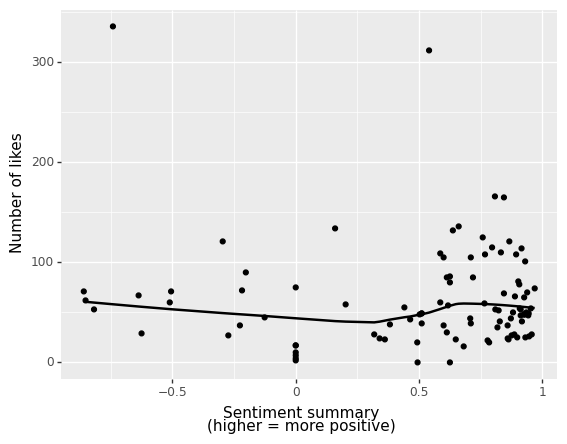

<ggplot: (8728963602393)>

In [19]:
## no clear relationship
(ggplot(senator_tweets_df, aes(x = 'compound_sent', y = 'public_metrics')) +
geom_point() +
xlab("Sentiment summary\n(higher = more positive)") +
ylab("Number of likes") +
geom_smooth())
